## Task 1

In [90]:
import os

import astropy.units as u
import matplotlib.pyplot as plt
import numpy as np

from astropy.time import Time, TimeDelta
from matplotlib import dates

In [91]:
bstfile = "./data/20190415_084119_bst_00X.dat"
data = np.fromfile(bstfile)
print("Number of data points:",data.shape[0])
print("File size:",os.path.getsize(bstfile))
print("Bitmode:",os.path.getsize(bstfile)/data.shape[0])

#bitmode is 8 therefore 488 subbands (not always full of data though)
t_len = data.shape[0]/488
print("Time samples:",t_len )

Number of data points: 6045832
File size: 48366656
Bitmode: 8.0
Time samples: 12389.0


## Task 2

In [92]:
data = data.reshape(-1,488)
data = data[:,:400]
# of data.reshape(data.shape[0]//488,488)

## Task 3

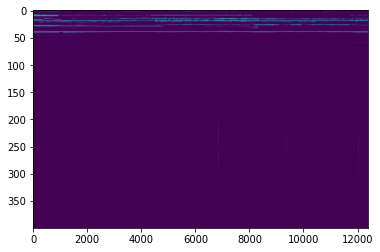

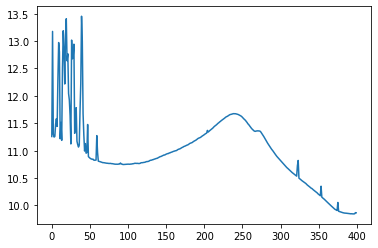

In [93]:
plt.imshow(data.T, aspect="auto")
plt.figure()
plt.plot(np.log10(np.sum(data,0)))

This is the antenna response for the LBAs therefore we are in mode 3!

## Task 4

In [94]:
def sb_to_freq(sb, obs_mode):
	"""
	Converts LOFAR single station subbands to frequency
	Returns frequency as astropy.units.Quantity (MHz)
	Inputs: subband number, observation mode (3, 5 or 7)
	"""
	nyq_zone_dict = {3:1, 5:2, 7:3}
	nyq_zone = nyq_zone_dict[obs_mode]
	clock_dict = {3:200, 4:160, 5:200, 6:160, 7:200} #MHz
	clock = clock_dict[obs_mode]
	freq = (nyq_zone-1+sb/512)*(clock/2)
	return freq*u.MHz #MHz


In [95]:
sbs = np.arange(51,450) #found from observing script
freqs = sb_to_freq(sbs, obs_mode=3)
obs_start = bstfile[len(bstfile)-27:len(bstfile)-12]
obs_start = Time.strptime(obs_start, "%Y%m%d_%H%M%S")
obs_len  = TimeDelta(data.shape[0]*u.s, format='sec')# timedelta(seconds = data.shape[0])
obs_end = obs_start + obs_len
t_lims = [obs_start.plot_date, obs_end.plot_date]

#you only really need start and end time for imshow but we'll do a full array anyway
t_arr = np.arange(0,t_len)
t_arr = t_arr*TimeDelta(1*u.s, format='sec')
t_arr = obs_start+t_arr
t_arr = t_arr.plot_date

Text(0, 0.5, 'Frequency (MHz)')

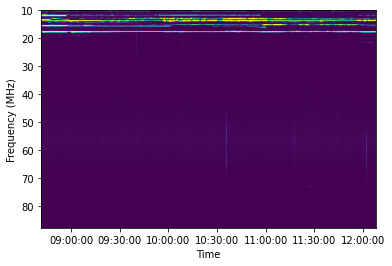

In [96]:
fig, ax = plt.subplots()
ax.imshow(data.T, aspect="auto", extent=[t_arr[0], t_arr[-1], freqs.value[-1], freqs.value[0]],
         vmin = np.percentile(data.T, 1), vmax = np.percentile(data.T, 99))
ax.xaxis_date()
date_format = dates.DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time")
plt.ylabel("Frequency (MHz)")

## Task 5

Text(0, 0.5, 'Frequency (MHz)')

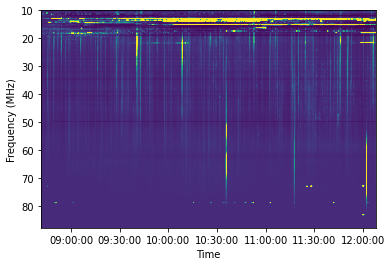

In [97]:
data = data/np.mean(data[10:20], axis=0)
fig, ax = plt.subplots()
ax.imshow(data.T, aspect="auto", extent=[t_arr[0], t_arr[-1], freqs.value[-1], freqs.value[0]],
         vmin = np.percentile(data.T, 1), vmax = np.percentile(data.T, 99))
ax.xaxis_date()
date_format = dates.DateFormatter("%H:%M:%S")
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time")
plt.ylabel("Frequency (MHz)")

## Task 6

Number of data points: 20851264
File size: 166810112
Bitmode: 8.0
Time samples: 42728.0


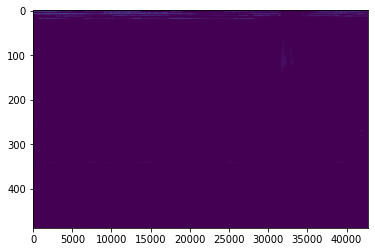

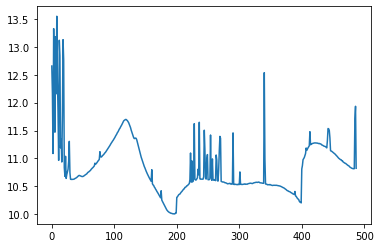

In [98]:
bstfile357 = "./data/20170910_070804_bst_00X.dat" #"data/modea/20190612_133144_bst_00X.dat"
data357 = np.fromfile(bstfile357)
print("Number of data points:",data357.shape[0])
print("File size:",os.path.getsize(bstfile357))
print("Bitmode:",os.path.getsize(bstfile357)/data357.shape[0])

t_len357 = data357.shape[0]/488
print("Time samples:",t_len357 )
data357 = data357.reshape(-1,488)

plt.imshow(data357.T, aspect="auto")
plt.figure()
plt.plot(np.log10(np.sum(data357,0)))

Set up frequency array for mode 357. This is very ugly, I'm sure someone could do it nicer.

In [99]:
data357 = data357.T
sbs = np.array((np.arange(54,454,2),np.arange(54,454,2),np.arange(54,230,2)), dtype=object)
blank_sbs = np.array((np.arange(454,512,2),np.arange(0,54,2),np.arange(454,512,2),np.arange(0,54,2)), dtype=object)
obs_mode = np.array((3,5,7))
blank_obs_mode = np.array((3,5,5,7))
freqs = np.array([sb_to_freq(sb,mode) for sb,mode in zip(sbs, obs_mode)], dtype=object)
blank_freqs = np.array([sb_to_freq(sb,mode) for sb,mode in zip(blank_sbs, blank_obs_mode)], dtype=object)

sbs=np.concatenate((sbs[0], blank_sbs[0], blank_sbs[1], sbs[1],
                            blank_sbs[2], blank_sbs[3], sbs[2]))

freqs=np.concatenate((freqs[0], blank_freqs[0], blank_freqs[1], freqs[1],
                            blank_freqs[2], blank_freqs[3], freqs[2]))


blank_data = np.zeros((freqs.shape[0],data357.shape[1]))
#1st 200 sbs mode 3, blank, next 200 sbs mode 5, blank, last 88 sbs mode 7
blank_data[:200,:] = data357[:200,:]
blank_len_0 = len(blank_freqs[0]) + len(blank_freqs[1])
blank_data[200 + blank_len_0:400 + blank_len_0,:] = data357[200:400,:]
blank_len_1 = len(blank_freqs[2]) + len(blank_freqs[3])
blank_data[400 + blank_len_0 + blank_len_1 :,:] = data357[400:,:]
data357 = blank_data

Now to plot it

<ipython-input-100-ece7e457c625>:8: RuntimeWarning: divide by zero encountered in log10
  plt.plot(np.log10(np.sum(data357,1)))


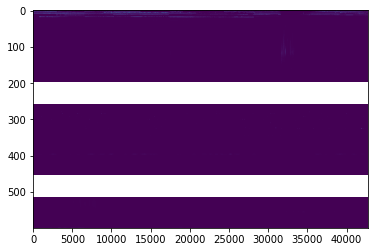

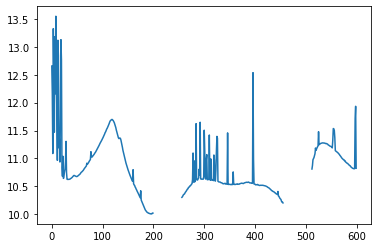

In [100]:
mask = np.zeros(data357.shape)
mask[200:256,:] = 1	#1st 200 sbs are mode 3, 56 blank sbs
mask[456:512,:] = 1 #Next 200 sbs are mode 5, 56 blank sbs. Last 88 sbs are mode 7
data357 = np.ma.array(data357, mask=mask)

plt.imshow(data357, aspect="auto")
plt.figure()
plt.plot(np.log10(np.sum(data357,1)))

In [101]:
obs_start357 = bstfile357[len(bstfile357)-27:len(bstfile357)-12]
obs_start357 = Time.strptime(obs_start357, "%Y%m%d_%H%M%S")
t_arr357 = np.arange(0,t_len357)
t_arr357 = t_arr357*TimeDelta(1*u.s, format='sec')
t_arr357 = obs_start357+t_arr357
t_arr357 = t_arr357.plot_date

Text(0, 0.5, 'Frequency (MHz)')

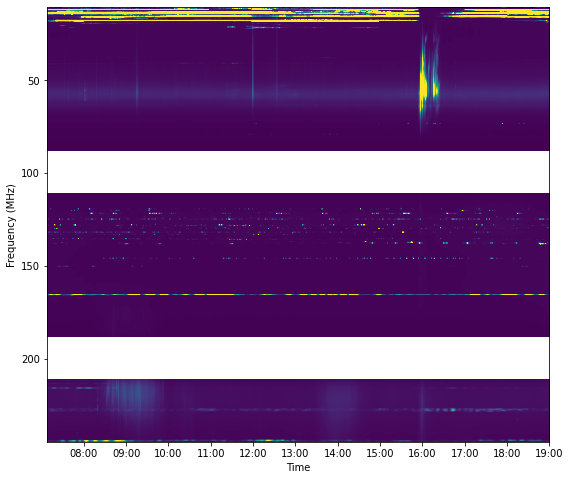

In [102]:
fig, ax = plt.subplots(figsize=(9,8))
ax.imshow(data357, aspect="auto", extent=[t_arr357[0], t_arr357[-1], freqs.value[-1], freqs.value[0]],
         vmin = np.percentile(data357, 1), vmax = np.percentile(data357, 99))
ax.xaxis_date()
date_format = dates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time")
plt.ylabel("Frequency (MHz)")

In [103]:
np.savez("./data/data357.npz", data357, freqs)

Remove antenna response


Text(0, 0.5, 'Frequency (MHz)')

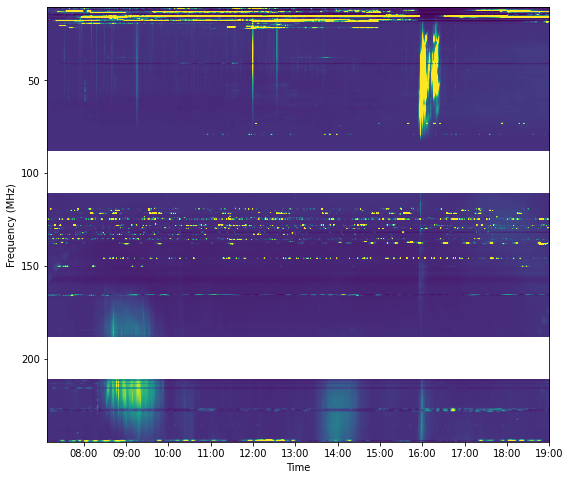

In [104]:
data357 = (data357.T/np.mean(data357[:,10:20], axis=1)).T
fig, ax = plt.subplots(figsize=(9,8))
ax.imshow(data357, aspect="auto", extent=[t_arr357[0], t_arr357[-1], freqs.value[-1], freqs.value[0]],
         vmin = np.percentile(data357, 1), vmax = np.percentile(data357, 99))
ax.xaxis_date()
date_format = dates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time")
plt.ylabel("Frequency (MHz)")

In [105]:
load_arr = np.load("./data/data357.npz")

In [123]:
d_load = load_arr['arr_0']
f_load = load_arr['arr_1']

In [124]:
mask = np.zeros(d_load.shape)
mask[200:256,:] = 1	#1st 200 sbs are mode 3, 56 blank sbs
mask[456:512,:] = 1 
d_load = np.ma.array(d_load, mask=mask)

Text(0, 0.5, 'Frequency (MHz)')

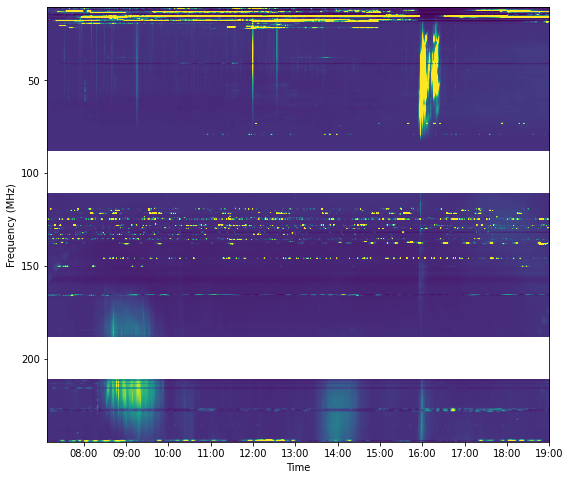

In [126]:
d_load = (d_load.T/np.mean(d_load[:,10:20], axis=1)).T
fig, ax = plt.subplots(figsize=(9,8))
ax.imshow(d_load, aspect="auto", extent=[t_arr357[0], t_arr357[-1], f_load[-1], f_load[0]],
         vmin = np.percentile(d_load, 1), vmax = np.percentile(d_load, 99))
ax.xaxis_date()
date_format = dates.DateFormatter("%H:%M")
ax.xaxis.set_major_formatter(date_format)
plt.xlabel("Time")
plt.ylabel("Frequency (MHz)")